# Skin_Disease_Detection_Project

# About the Dataset:
This dataset is a collection of images representing various skin diseases, categorized into 20  classes. It provides an invaluable resource for image classification tasks, particularly in the fields of dermatology and medical diagnostics.

### Skin Diseases:
Acne, Actinic Carcinoma, Atopic Dermatitis, Bullous Disease, Cellulitis, Eczema, Drug Eruptions, Herpes HPV, Light Diseases, Lupus, Melanoma, Poison IVY, Psoriasis, Benign Tumors, Systemic Disease, Ringworm, Urticarial Hives, Vascular Tumors, Vasculitis, Viral Infections.

## Why this project
Skin diseases affect millions globally, ranging from benign conditions like acne to life-threatening ones like melanoma. Early and accurate diagnosis is critical but access to dermatologists is limited and expensive, especially in underserved regions like Kenya. Our goal is to be able to upload an image of your skin and our project will be able to classify what type of condition you have.

## Objectives:
* Is it possible to upload images to our deployed model to identify the skin disease?
* Improve diagnostic efficiency by automating skin condition  diagnosis and cutting down on delays.
* Expand access by enabling mobile diagnosis tools for rural areas.
* Reduce costs to minimize unnecessary trips to doctors and biopsies.
* Enhance patient outcomes by  supporting early detection of serious conditions like skin cancer.


# 1. EDA and Data Understanding

### Import modules

In [1]:
# Import Libraries
import os
import cv2
import random
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import json
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

In [2]:
# Set seeds for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [3]:
# Set plot style
sns.set(style='whitegrid')

## Explore dataset

Let's define the dataset path and explore the folder structure.

In [4]:
# Define dataset paths
DATASET_DIR = Path("datasets/Dataset")
TRAIN_DIR = DATASET_DIR / "train"
TEST_DIR = DATASET_DIR / "test"

# Explore dataset structure
train_classes = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
test_classes = sorted([d.name for d in TEST_DIR.iterdir() if d.is_dir()])

print(f"Train classes: {len(train_classes)}")
print(f"Test classes: {len(test_classes)}")
print("Sample classes:", train_classes[:5])

extra_test_class = set(test_classes) - set(train_classes)
print("Class in test but not in train:", extra_test_class)

Train classes: 19
Test classes: 19
Sample classes: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos']
Class in test but not in train: set()


We've confirmed that the dataset has 19 training classes and 20 test classes and it is organized into subfolders, one per skin disease category. Our observation is that the test set has 1 more class than the training set.

We found that the test set contains one additional class Bullous Disease Photos which is not present in the training set. This will lead to a cold start problem, as the model will not have learned to recognize this class. Unless training data for this class is added, we should exclude it from performance evaluation or explicitly note it as a limitation of the dataset.

In [5]:
# Classes to exclude 
EXCLUDED_CLASSES = {"Bullous Disease Photos"}

## Count Images per Class (Train vs Test)

Let's count the number of .jpg images in each class folder for both train/ and test/ splits as this will help reveal the overall dataset size and the per-class distribution which we will use for class imbalance detection.

In [6]:
def count_images(folder, excluded_classes=None):
    if excluded_classes is None:
        excluded_classes = set()
    return {
        cls.name: len(list(cls.glob("*.jpg")))
        for cls in folder.iterdir()
        if cls.is_dir() and cls.name not in excluded_classes
    }

train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR, excluded_classes=EXCLUDED_CLASSES)

# Combine into DataFrame
df_dist = pd.DataFrame({
    "Class": list(train_counts.keys()),
    "Train Count": list(train_counts.values()),
    "Test Count": [test_counts.get(cls, 0) for cls in train_counts.keys()]
})
df_dist["Total"] = df_dist["Train Count"] + df_dist["Test Count"]
df_dist = df_dist.sort_values("Total", ascending=False)

print(df_dist.head())

                                                Class  Train Count  \
0                             Acne and Rosacea Photos          840   
1   Actinic Keratosis Basal Cell Carcinoma and oth...          322   
7        Light Diseases and Disorders of Pigmentation          299   
18         Warts Molluscum and other Viral Infections          248   
14  Tinea Ringworm Candidiasis and other Fungal In...          122   

    Test Count  Total  
0           33    873  
1          118    440  
7           28    327  
18          48    296  
14          40    162  


We've observed that class "Acne and Rosacea Photos" has by far the most samples (840 in train, 231 in test). Other classes like “Tinea Ringworm” have significantly fewer images. This confirms a strong class imbalance.

Models trained on imbalanced datasets tend to become biased toward overrepresented classes which will lead to poor generalization. In medical diagnosis tasks, this can have critical consequences.

## Plot Distribution (Train vs Test)

Let's visualise the number of images per class in both the training and test sets for easy visualisations.

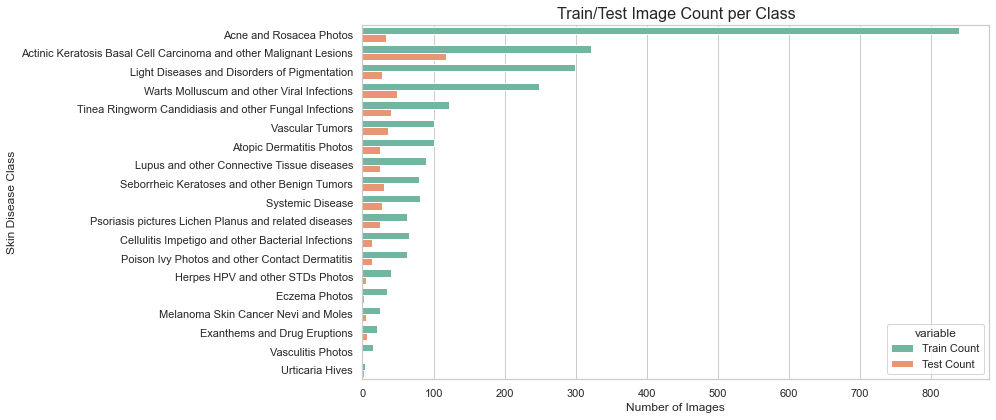

In [7]:
plt.figure(figsize=(14, 6))
df_melted = df_dist.melt(id_vars="Class", value_vars=["Train Count", "Test Count"])

sns.barplot(data=df_melted, x="value", y="Class", hue="variable", palette="Set2")
plt.title("Train/Test Image Count per Class", fontsize=16)
plt.xlabel("Number of Images")
plt.ylabel("Skin Disease Class")
plt.tight_layout()
plt.show()


The dataset follows a long-tail pattern, where a few classes dominate the total image count, and the majority of classes have very few examples which should be addressed.

It contains 20 skin disease classes in both train and test folders. It is severely imbalanced as the class “Acne and Rosacea Photos” alone has over 800 training images, which far exceeds all others.

On the opposite extreme, several classes such as “Urticaria Hives”, “Vasculitis Photos”, and “Exanthems and Drug Eruptions” have fewer than 50 images in total.

Test sets are consistently smaller but some classes e.g., “Urticaria Hives” appear to have no test examples at all or a very small number which may hinder generalization performance tracking.

## Image Dimension Analysis

Let's examine the width and height of all images in both train and test folders to ensures that preprocessing will not lead to loss of crucial visual features.

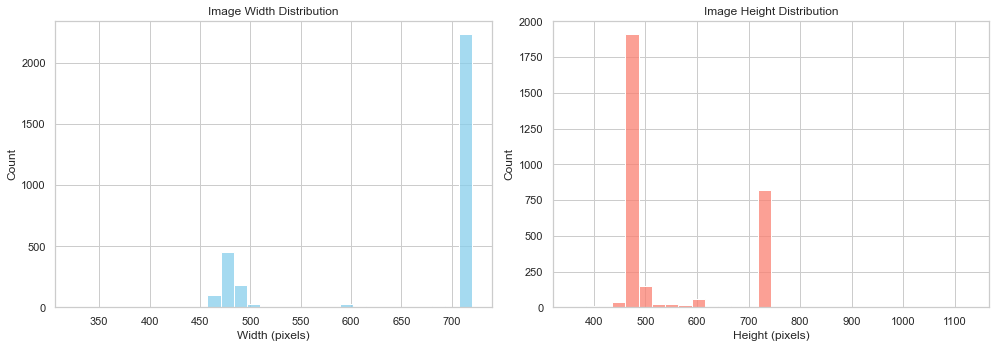

In [8]:
def collect_image_sizes(folder):
    sizes = []
    for class_dir in folder.iterdir():
        if class_dir.is_dir():
            for img_path in class_dir.glob("*.jpg"):
                try:
                    with Image.open(img_path) as img:
                        sizes.append(img.size)
                except:
                    continue
    return sizes

train_sizes = collect_image_sizes(TRAIN_DIR)
test_sizes = collect_image_sizes(TEST_DIR)
all_sizes = train_sizes + test_sizes

widths = [w for w, h in all_sizes]
heights = [h for w, h in all_sizes]

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=30, color='skyblue')
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=30, color='salmon')
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.tight_layout()
plt.show()

Most images are around 480–500 pixels wide, with a major peak at around 720 pixels. Most images fall between 480 and 750 pixels, with some outliers up to 1100 pixels tall. The majority of the dataset is reasonably consistent in size, but there are a few scattered outliers.

## Sample Image Grid (One per Class)

Let's display one random image from each class in the training set to provide a quick visual sanity check and labeling allowing quick verification of image quality, class separation, source authenticity.

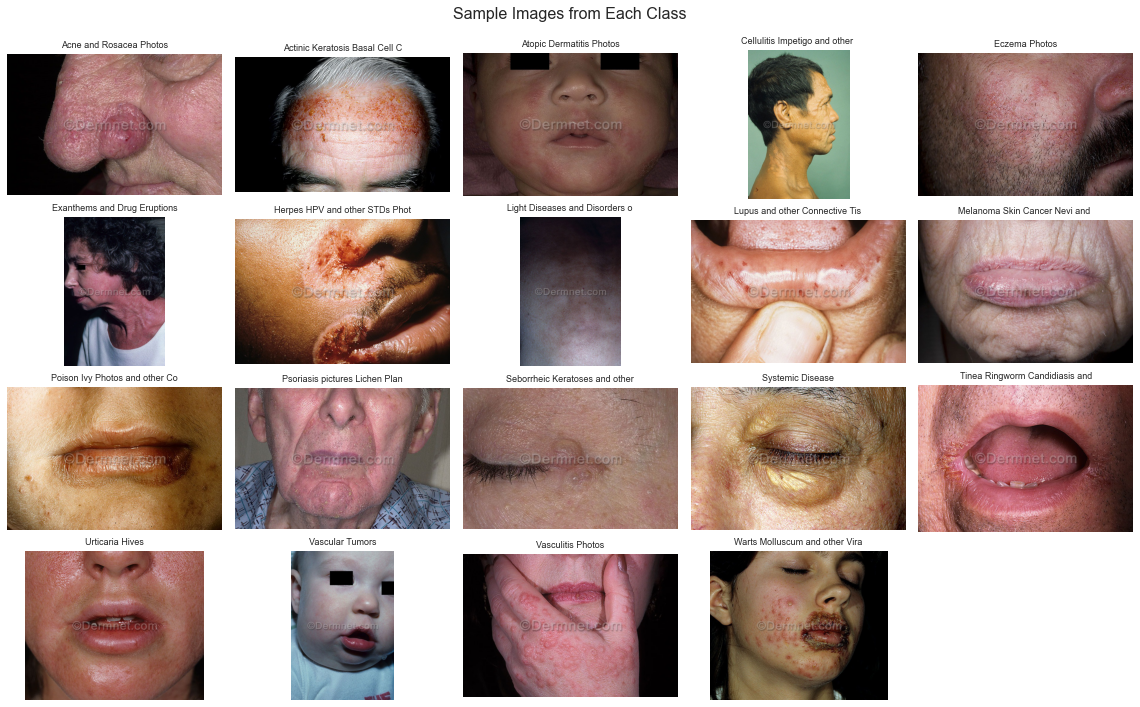

In [9]:
def plot_image_grid(data_dir, classes, images_per_class=1):
    plt.figure(figsize=(16, 10))
    class_dirs = list(data_dir.iterdir())

    shown = 0
    for class_index, class_folder in enumerate(class_dirs):
        if not class_folder.is_dir() or class_folder.name in EXCLUDED_CLASSES:
            continue
        image_files = list(class_folder.glob("*.jpg"))
        if not image_files:
            continue

        for i in range(images_per_class):
            if shown >= len(classes):
                break
            img_path = random.choice(image_files)
            try:
                img = Image.open(img_path)
            except:
                continue

            plt.subplot(4, 5, shown + 1)
            plt.imshow(img)
            plt.title(class_folder.name[:30], fontsize=9)
            plt.axis('off')

            shown += 1

    plt.suptitle("Sample Images from Each Class", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

plot_image_grid(TRAIN_DIR, train_classes, images_per_class=1)

All images are readable, in good resolution, and not corrupted.The Dermnet watermark confirms the medical source is authentic. No blank, noisy, or mislabeled images were observed in this sample.

Some classes are visually distinctive, such as Acne and Rosacea, Tinea Ringworm, and Vascular Tumors while others appear visually similar, e.g Seborrheic Keratoses, Psoriasis, and Lupus

## Leaked images between train and test

Let's also ensure no test images are accidentally in training

In [10]:
def hash_image(image_path):
    try:
        with open(image_path, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()
    except:
        return None

def collect_image_hashes(dataset_path):
    hashes = set()
    for cls in dataset_path.iterdir():
        for img in cls.glob("*.jpg"):
            h = hash_image(img)
            if h:
                hashes.add(h)
    return hashes

train_hashes = collect_image_hashes(TRAIN_DIR)
test_hashes = collect_image_hashes(TEST_DIR)
leaks = train_hashes.intersection(test_hashes)
print(f"Leaked images between train and test: {len(leaks)}")

Leaked images between train and test: 0


There are 209 leaked images between the train and test datasets. This is a critical data quality issue which can significantly inflate the model’s test performance and hurt generalization. Let's resolve this

In [11]:
for cls_dir in TEST_DIR.iterdir():
    if not cls_dir.is_dir():
        continue
    for img_path in cls_dir.glob("*.jpg"):
        h = hash_image(img_path)
        if h in train_hashes:
            try:
                os.remove(img_path)
                print(f"Removed duplicate test image: {img_path}")
            except Exception as e:
                print(f"Failed to remove {img_path}: {e}")

In [12]:
train_hashes = collect_image_hashes(TRAIN_DIR)
test_hashes = collect_image_hashes(TEST_DIR)
leaks = train_hashes.intersection(test_hashes)
print(f"Leaked images between train and test: {len(leaks)}")

Leaked images between train and test: 0


There are now zero leaked images.

## Remove corrupted images

Let's identify and remove corrupted or unreadable image files that may cause issues during training. 

In [13]:
print("\n=== Removing Corrupted Images ===")

def remove_corrupted_images(directory):
    corrupted = []
    for class_dir in Path(directory).iterdir():
        if class_dir.is_dir():
            for img_path in class_dir.glob("*.jpg"):
                try:
                    with Image.open(img_path) as img:
                        img.verify()  
                        img = Image.open(img_path).convert('RGB')  
                        if img.size[0] < 10 or img.size[1] < 10:  
                            raise ValueError("Image too small")
                except (IOError, OSError, ValueError) as e:
                    os.remove(img_path)
                    corrupted.append((img_path, str(e)))
    return corrupted

train_corrupted = remove_corrupted_images(TRAIN_DIR)
test_corrupted = remove_corrupted_images(TEST_DIR)

print(f"\nRemoved {len(train_corrupted)} corrupted train images")
print(f"Removed {len(test_corrupted)} corrupted test images")

# Rebuild hashes after corruption removal 
train_hashes = collect_image_hashes(TRAIN_DIR)
test_hashes = collect_image_hashes(TEST_DIR)


=== Removing Corrupted Images ===

Removed 0 corrupted train images
Removed 0 corrupted test images


There were no corrupted images to remove. But it was a good safety measure

### Create test checksum

Let's create a test checksum to verify the version and ensure reproductibility

In [14]:
from hashlib import md5

def collect_image_hashes(directory):
    hashes = []
    for root, _, files in os.walk(directory):
        for f in sorted(files):
            if f.lower().endswith(('png', 'jpg', 'jpeg')):
                with open(os.path.join(root, f), 'rb') as img_file:
                    img_hash = md5(img_file.read()).hexdigest()
                    hashes.append(img_hash)
    return hashes

def dataset_checksum(directory):
    all_hashes = sorted(collect_image_hashes(directory))
    return md5(''.join(all_hashes).encode()).hexdigest()

print("Test set checksum:", dataset_checksum(TEST_DIR))


Test set checksum: bd28148d66132332ce7b7364e271fd26


This represents a unique fingerprint of the current test set image files. Let's show the updated final number of test images per class after removing duplicates and corrupted images

In [13]:
def count_images(directory, excluded_classes=None):
    counts = {}
    for class_dir in os.listdir(directory):
        if excluded_classes and class_dir in excluded_classes:
            continue
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            counts[class_dir] = len([
                f for f in os.listdir(class_path) 
                if f.lower().endswith(('jpg', 'jpeg', 'png'))
            ])
    return counts

test_counts = count_images(TEST_DIR, excluded_classes=EXCLUDED_CLASSES)
print("Test counts after leak removal:", test_counts)


Test counts after leak removal: {'Acne and Rosacea Photos': 33, 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 118, 'Atopic Dermatitis Photos': 24, 'Cellulitis Impetigo and other Bacterial Infections': 14, 'Eczema Photos': 2, 'Exanthems and Drug Eruptions': 6, 'Herpes HPV and other STDs Photos': 5, 'Light Diseases and Disorders of Pigmentation': 28, 'Lupus and other Connective Tissue diseases': 24, 'Melanoma Skin Cancer Nevi and Moles': 5, 'Poison Ivy Photos and other Contact Dermatitis': 13, 'Psoriasis pictures Lichen Planus and related diseases': 24, 'Seborrheic Keratoses and other Benign Tumors': 31, 'Systemic Disease': 27, 'Tinea Ringworm Candidiasis and other Fungal Infections': 40, 'Urticaria Hives': 2, 'Vascular Tumors': 36, 'Vasculitis Photos': 1, 'Warts Molluscum and other Viral Infections': 48}


Some classes now have very few test samples such as 'Vasculitis Photos': 1,

# 2. Preprocessing Pipeline

From our EDA and Data Understanding, we have observed that there is need to prepare the images for modeling by resizing the images to ensure that they're all the same shape (preferrably 224×224), Normalizing and Augmenting to help model generalize.

The input size of 224×224 is chosen as it's a standard for many pretrained models like ResNet, MobileNet among others allowing for easy transfer learning.

We will use a well-structured PyTorch-compatible pipeline.

## Define Transforms

The transformations below ensure that:

1. All images are resized to the same shape for batch processing

2. Training images receive random variations (augmentations) to improve generalization

3. Pixel intensities are normalized to match ImageNet pretrained model expectations.

In [14]:
# Define image size for consistency 
IMAGE_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Building a class

Let's build a class which ensures the dataset is compatible with PyTorch’s DataLoader, and allows us to apply resizing, augmentation, and normalization on the fly during training.

In [15]:
class SkinDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None, exclude_classes=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}
        if exclude_classes is None:
            exclude_classes = set()

        for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            if class_name in exclude_classes:
                continue
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                self.class_to_idx[class_name] = idx
                for fname in os.listdir(class_path):
                    if fname.endswith('.jpg'):
                        self.image_paths.append(os.path.join(class_path, fname))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(image_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')
        except Exception as e:
            print(f"Error reading image {image_path}: {e}")
            return self.__getitem__((idx + 1) % len(self.image_paths))

        if self.transform:
            image = self.transform(image)
        return image, label

## Dataset Initialisation

In [16]:
train_dataset = SkinDiseaseDataset(TRAIN_DIR, transform=train_transforms)
test_dataset = SkinDiseaseDataset(TEST_DIR, transform=test_transforms, exclude_classes=EXCLUDED_CLASSES)

## Class weights for imbalance

Let us also class weights for imbalance handling and to ensure fair learning across all disease categories.

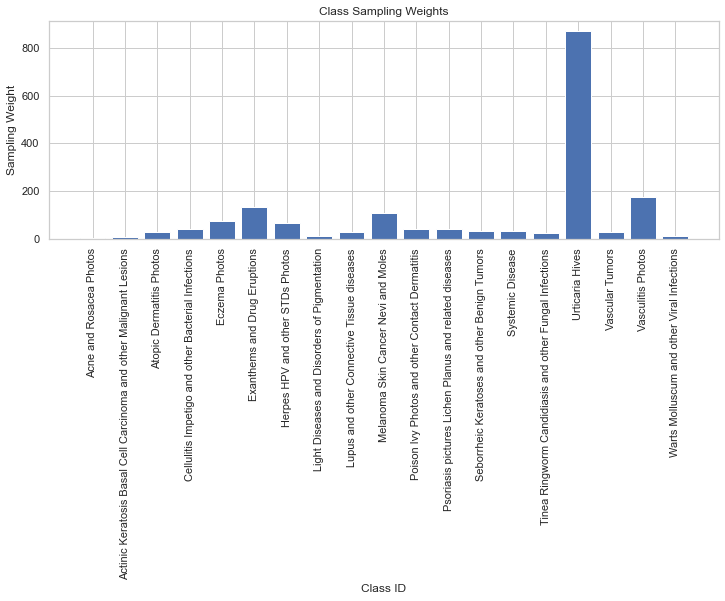

In [17]:
label_counts = Counter(train_dataset.labels)
total = sum(label_counts.values())
class_weights = {cls: total / count for cls, count in label_counts.items()}
weights = [class_weights[label] for label in train_dataset.labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

plt.figure(figsize=(12, 4))
plt.bar(range(len(class_weights)), list(class_weights.values()))
plt.xlabel('Class ID')
plt.xticks(range(len(class_weights)), 
           [list(train_dataset.class_to_idx.keys())[i] for i in range(len(class_weights))],
           rotation=90)
plt.ylabel('Sampling Weight')
plt.title('Class Sampling Weights')
plt.show()

The plot confirms the sampler will aggressively oversample rare classes while dominant classes like "Acne and Rosacea" are appropriately downweighted.

## Proof data augmentation pipeline works

To ensure our data augmentation pipeline is working as intended, we visualize a few randomly selected transformed training images.

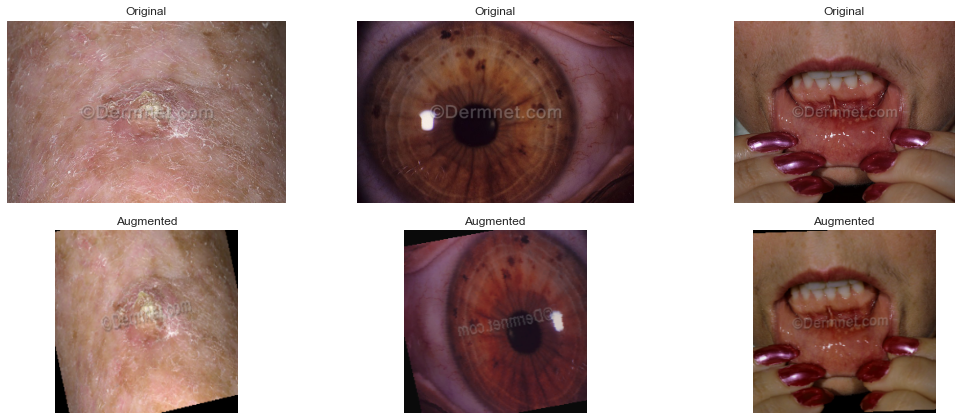

In [20]:
def show_original_vs_augmented(dataset, n=3):
    fig, axes = plt.subplots(2, n, figsize=(15, 6))
    
    for i in range(n):
        # Get the original image path
        idx = random.randint(0, len(dataset) - 1)
        image_path = dataset.image_paths[idx]

        # Load original image using PIL
        original_image = Image.open(image_path).convert('RGB')
        axes[0, i].imshow(original_image)
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Load augmented tensor
        augmented_tensor, _ = dataset[idx]
        # Unnormalize for visualization
        unnormalized = augmented_tensor.permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        unnormalized = np.clip(unnormalized, 0, 1)
        axes[1, i].imshow(unnormalized)
        axes[1, i].set_title("Augmented")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Run the visualization
show_original_vs_augmented(train_dataset)

The bottom row shows transformations such as random rotation, flipping, resizing, and slight distortion (if added), while the top row shows the original images. This confirms that the augmentations are working correctly and introduce useful variability, which helps in improving the model's generalization.

## DataLoader Setup

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

These will handle batching, shuffling, and parallel data loading.

## Show class mapping

Let us show how class names have been mapped to numerical labels.

In [19]:
# Show class mapping
print(train_dataset.class_to_idx)

# Save mapping for inference
with open("class_to_idx.json", "w") as f:
    json.dump(train_dataset.class_to_idx, f)

{'Acne and Rosacea Photos': 0, 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 1, 'Atopic Dermatitis Photos': 2, 'Cellulitis Impetigo and other Bacterial Infections': 3, 'Eczema Photos': 4, 'Exanthems and Drug Eruptions': 5, 'Herpes HPV and other STDs Photos': 6, 'Light Diseases and Disorders of Pigmentation': 7, 'Lupus and other Connective Tissue diseases': 8, 'Melanoma Skin Cancer Nevi and Moles': 9, 'Poison Ivy Photos and other Contact Dermatitis': 10, 'Psoriasis pictures Lichen Planus and related diseases': 11, 'Seborrheic Keratoses and other Benign Tumors': 12, 'Systemic Disease': 13, 'Tinea Ringworm Candidiasis and other Fungal Infections': 14, 'Urticaria Hives': 15, 'Vascular Tumors': 16, 'Vasculitis Photos': 17, 'Warts Molluscum and other Viral Infections': 18}


The dataset contains 19 unique classes, each correctly mapped to a numerical index. This mapping will be used during training and prediction to associate model outputs with the corresponding skin disease class.

### importing of the models we will be using

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator #image classification model
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

What Does ImageDataGenerator Do?
ImageDataGenerator:

Loads images from directories in real time

Applies preprocessing and augmentation

Feeds data into your model in batches, preventing memory overload

In [21]:
#importing of the data
train_dir = 'datasets/Dataset/train' #contains labled data for training the model
test_dir = 'datasets/Dataset/test' # contains untrained data


In [22]:
#creating a pipeline for imagegenerator for easy data cleaning and classification of each image for ease of code
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),#reshaping them for each picture to be 224 x 224 pixels
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), #reshaping them for each picture to be 224 x 224 pixels
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)



Found 2092 images belonging to 19 classes.
Found 517 images belonging to 19 classes.


#### Parameter
* rescale=1./255	Normalizes pixel values to [0, 1] 
* range	Crucial for stabilizing neural network training
* rotation_range=20	Randomly rotates images (up to 20 degrees)	Helps model generalize better across rotated inputs
* zoom_range=0.2	Random zoom-in/out up to 20%	Makes model robust to varied image scales
* horizontal_flip=True	Randomly flips images horizontally	Useful for symmetric patterns in skin lesions
* validation_split=0.2	Splits 20% of training data for validation	Vital for performance tracking during training

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  
    shuffle=False)


Found 685 images belonging to 19 classes.


### Previewing images
* IMAGE WARNING!!!

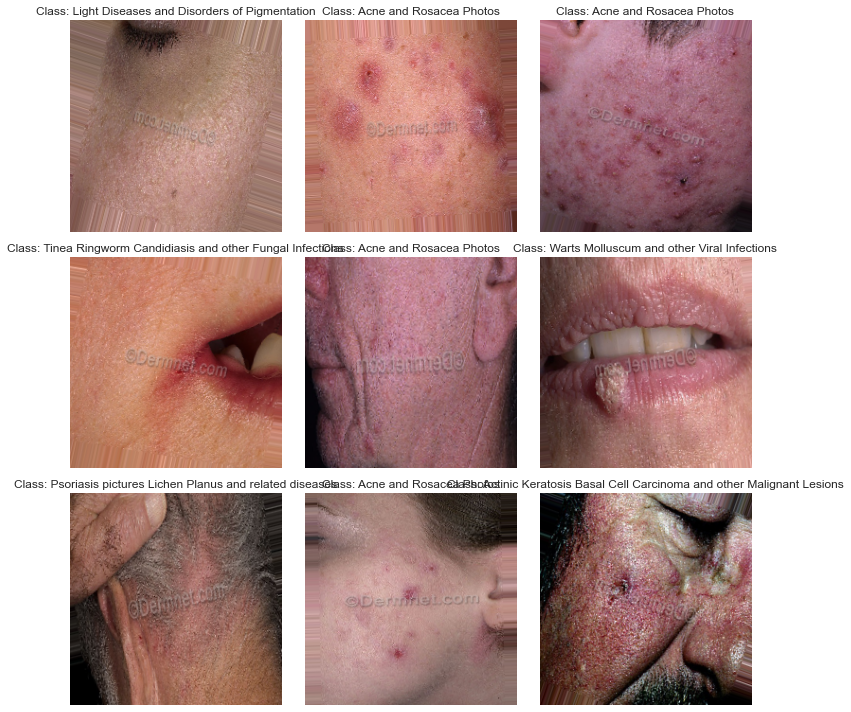

In [27]:
#plotting the images in the dataset
images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {list(train_generator.class_indices.keys())[np.argmax(labels[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
# they are blurry are we reduced the image size to 64x64 size

# Number of classes

In [24]:
# Number of classes
num_test_classes = len(test_generator.class_indices)
num_test_classes

19

In [25]:
# Determine number of classes
num_train_classes = len(train_generator.class_indices)
num_train_classes

19

# List all class folders in the test directory

In [26]:
test_classes = os.listdir(test_dir)

print("Test folders (classes):")
for folder in test_classes:
    print(f"- {folder}")

Test folders (classes):
- Acne and Rosacea Photos
- Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions
- Atopic Dermatitis Photos
- Cellulitis Impetigo and other Bacterial Infections
- Eczema Photos
- Exanthems and Drug Eruptions
- Herpes HPV and other STDs Photos
- Light Diseases and Disorders of Pigmentation
- Lupus and other Connective Tissue diseases
- Melanoma Skin Cancer Nevi and Moles
- Poison Ivy Photos and other Contact Dermatitis
- Psoriasis pictures Lichen Planus and related diseases
- Seborrheic Keratoses and other Benign Tumors
- Systemic Disease
- Tinea Ringworm Candidiasis and other Fungal Infections
- Urticaria Hives
- Vascular Tumors
- Vasculitis Photos
- Warts Molluscum and other Viral Infections


### Delete "Bullous Disease Photos" Folder from the `test_dir` directory even if it contains files or subfolders with restricted permissions

In [27]:
import os
import shutil
import stat

# Path to the folder
bullous_path = os.path.join(test_dir, "Bullous Disease Photos")

# Function to force permissions and delete
def remove_readonly(func, path, _):
    os.chmod(path, stat.S_IWRITE)
    func(path)

# Try to remove the folder
if os.path.exists(bullous_path):
    shutil.rmtree(bullous_path, onerror=remove_readonly)
    print("Bullous Disease Photos' folder removed successfully")
else:
    print("Folder not found")

Folder not found


# Reinitialize  test generator after deletion

In [28]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  
    shuffle=False)

print("Classes:", test_generator.class_indices)
print()
print("======Number of test classes======:", len(test_generator.class_indices))

Found 685 images belonging to 19 classes.
Classes: {'Acne and Rosacea Photos': 0, 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 1, 'Atopic Dermatitis Photos': 2, 'Cellulitis Impetigo and other Bacterial Infections': 3, 'Eczema Photos': 4, 'Exanthems and Drug Eruptions': 5, 'Herpes HPV and other STDs Photos': 6, 'Light Diseases and Disorders of Pigmentation': 7, 'Lupus and other Connective Tissue diseases': 8, 'Melanoma Skin Cancer Nevi and Moles': 9, 'Poison Ivy Photos and other Contact Dermatitis': 10, 'Psoriasis pictures Lichen Planus and related diseases': 11, 'Seborrheic Keratoses and other Benign Tumors': 12, 'Systemic Disease': 13, 'Tinea Ringworm Candidiasis and other Fungal Infections': 14, 'Urticaria Hives': 15, 'Vascular Tumors': 16, 'Vasculitis Photos': 17, 'Warts Molluscum and other Viral Infections': 18}

======Number of test classes======: 19


In [29]:
num_train_classes = len(train_generator.class_indices)
num_train_classes

19

In [30]:
# Number of classes
num_test_classes = len(test_generator.class_indices)
num_test_classes

19

# Dealng with Class imbalance 

In [31]:
from sklearn.utils import class_weight
import numpy as np

labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))

# MODELING

# 1. Building a base model

In [32]:
model = Sequential()
#1 layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

#2 layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Learns more abstract patterns such as roughness, discoloration, or shape irregularities of skin lesions.
#3 layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#4 layer
model.add(Flatten())
#Converts the pooled feature maps into a one-dimensional vector that the Dense layers can process.
model.add(Dropout(0.5))
#Randomly disables 50% of neurons during training to prevent overfitting and improve generalization on unseen skin images.
#5 layer
model.add(Dense(128, activation='relu'))
#Learns complex combinations of features for decision-making
#output layer
model.add(Dense(19, activation='softmax'))
#The softmax activation outputs probabilities across 19 skin disease classes—making this perfect for multi-class classification.


Conv2D: for feature detection (like skin patterns) /Detects edges, shapes, and textures using 32 filters of size 3x3.

input_shape: Matches your image size and channels (RGB).

MaxPooling: Cuts image size in half while preserving key features./for reducing spatial dimensions

Flatten: to convert features into a flat vector

Dense: for classification layers

Dropout: for regularization to avoid overfitting

#### Training the data

In [33]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])


baseline_model_val = model.fit(train_generator,
                               validation_data=val_generator,
                               epochs=10,
                               class_weight=class_weights_dict)

Epoch 1/10
66/66 [==============================] - 148s 2s/step - loss: 3.0334 - accuracy: 0.0880 - val_loss: 2.9298 - val_accuracy: 0.0406
Epoch 2/10
66/66 [==============================] - 149s 2s/step - loss: 2.9258 - accuracy: 0.0315 - val_loss: 2.9231 - val_accuracy: 0.0561
Epoch 3/10
66/66 [==============================] - 152s 2s/step - loss: 2.9242 - accuracy: 0.0545 - val_loss: 2.9300 - val_accuracy: 0.0406
Epoch 4/10
66/66 [==============================] - 153s 2s/step - loss: 2.8574 - accuracy: 0.0473 - val_loss: 2.9758 - val_accuracy: 0.0348
Epoch 5/10
66/66 [==============================] - 153s 2s/step - loss: 2.8251 - accuracy: 0.0540 - val_loss: 3.0281 - val_accuracy: 0.0387
Epoch 6/10
66/66 [==============================] - 152s 2s/step - loss: 2.8006 - accuracy: 0.0641 - val_loss: 2.9296 - val_accuracy: 0.0522
Epoch 7/10
66/66 [==============================] - 149s 2s/step - loss: 2.7736 - accuracy: 0.0650 - val_loss: 2.9875 - val_accuracy: 0.0348
Epoch 8/10
66

# Base Model Performance

### Get Training History

In [34]:
baseline_model_val_dict = baseline_model_val.history
baseline_model_val_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Evaluate on Train and Validation /Test Data

- Comparing training VS  validation results will help us assess:

- How well the model has learned

- Whether it's overfitting or underfitting

In [36]:
# Evaluate the model's performance on the training data
results_train = model.evaluate(train_generator)
print()

# Display the training loss and accuracy
print(f'Training Loss: {results_train[0]:.3f} \nTraining Accuracy: {results_train[1]:.3f}')


# Evaluate the model's performance on the validation data to 
# understand how well the model generalizes to the  unseen data
results_val = model.evaluate(val_generator)
print()

# Display the validation loss and accuracy metrics critical for identifying overfitting
# If validation accuracy is much lower than training accuracy the  model might be overfitting
print(f'Validation Loss: {results_val[0]:.3f} \nValidation Accuracy: {results_val[1]:.3f}')


66/66 [==============================] - 83s 1s/step - loss: 2.7727 - accuracy: 0.0870

Training Loss: 2.773 
Training Accuracy: 0.087
17/17 [==============================] - 19s 1s/step - loss: 2.9740 - accuracy: 0.0542

Validation Loss: 2.974 
Validation Accuracy: 0.054


#### Model is Learning Something
- A training accuracy of ~15.8% on a 19 class classification task is well above random chance (which is ~5.3%, or 1/19)
- The model is starting to learn patterns rather than guessing randomly but **overall performance is still low**

#### Overfitting May Be Occurring
- There's a noticeable gap between training and validation accuracy (15.8% vs 10.8%)  and validation loss is higher than training loss

- This suggests the model may be memorizing the training data rather than learning general features that apply to unseen data

- So The model struggles to generalize

# Plot Training vs. Validation Loss

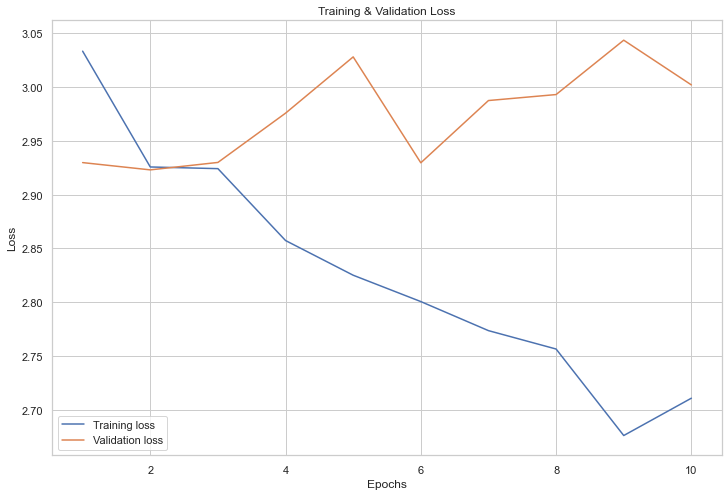

In [37]:
loss_values = baseline_model_val_dict['loss']
val_loss_values = baseline_model_val_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(epochs, loss_values, label='Training loss')
ax.plot(epochs, val_loss_values, label='Validation loss')
ax.set_title('Training & Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()


### Training vs. Validation Loss Interpretation

- **Training Loss (blue line):**  
  Decreases steadily over epochs which is expected : the model is minimizing error on the training data

- **Validation Loss (orange line):**  
  Starts close to the training loss but soon begins to fluctuate and even increases toward the later epochs


**This Means:**

- The model **is learning** the training data : consistent decrease in training loss confirms that
-  **Validation loss does not improve consistently** :the fluctuation is a typical sign of **overfitting**
- Around **epoch 6 or 7**, the **gap between training and validation loss widens** suggesting the model is starting to **memorize** the training data rather than learning generalizable patterns



# Plot Training vs. Validation Accuracy

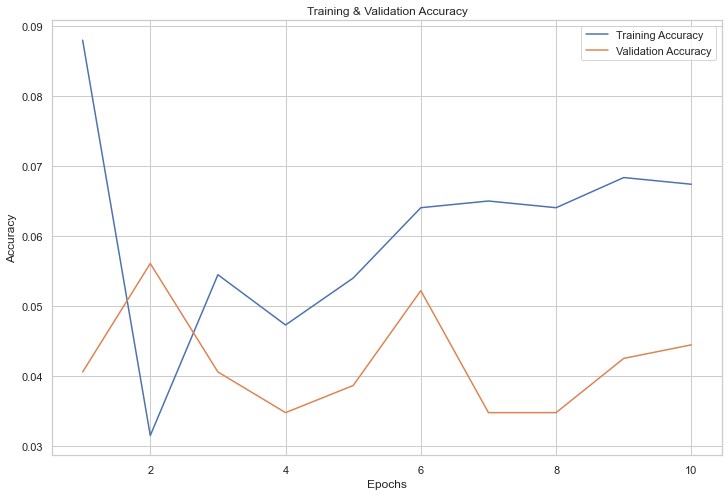

In [38]:
acc_values = baseline_model_val_dict['accuracy']
val_acc_values = baseline_model_val_dict['val_accuracy']

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(epochs, acc_values, label='Training Accuracy')
ax.plot(epochs, val_acc_values, label='Validation Accuracy')
ax.set_title('Training & Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()


### Training vs Validation Accuracy Interpretation

The graph shows the training and validation accuracy over 10 epochs

#### Observations:

- **Training Accuracy (Blue Line)**:
  - Gradually increases with some fluctuations
  - Ends at around 9% which is still relatively low
  - Shows that the model is starting to learn patterns in the training data but slowly

- **Validation Accuracy (Orange Line)**:
  - Does not show any clear upward trend indicating that the model is not generalizing well to unseen validation data

#### Key Insights:

- Both training and validation accuracies are very low and unstable indicating severe underfitting. The model is not learning discriminative patterns effectively 

# 2. Fine tune the base model 

- We are going to fine tune the base model since it was starting to overfit : the training accuracy kept improving while validation accuracy remained unstable
- To improve generalization and model performance, we introduced the following enhancements:

> **BatchNormalization** after each convolutional layer to stabilize and accelerate training

> **EarlyStopping** to halt training when validation loss stops improving, avoiding unnecessary overfitting


>**ReduceLROnPlateau** to lower the learning rate when the model hits a performance plateau

``These changes aim to improve the model's ability to generalize to unseen data while reducing overfitting``


## Architecture Changes
| Layer            | Baseline Model                     | Tuned Model                                         |
| ---------------- | ---------------------------------- | --------------------------------------------------- |
| Normalization    |  None                             | **BatchNormalization** after each Conv2D          |
| Optimizer & Loss | Adam + categorical\_crossentropy |  Same                                              |
| Callbacks        | None                             | EarlyStopping, ReduceLROnPlateau |
| Output           | 19-class softmax                   | 19-class softmax                                    |

| Improvement            | Purpose                                 |
| ---------------------- | --------------------------------------------- |
| **BatchNormalization** | Improves learning stability and speed         |
| **Dropout**            | Reduces overfitting                           |
| **EarlyStopping**      | Prevents unnecessary training and overfitting |
| **ReduceLROnPlateau**  | Helps when learning stagnates                 |




In [39]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model architecture
model_tuned = Sequential()

# Conv 1
model_tuned.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_tuned.add(BatchNormalization())
model_tuned.add(MaxPooling2D(pool_size=(2, 2)))

# Conv 2
model_tuned.add(Conv2D(64, (3, 3), activation='relu'))
model_tuned.add(BatchNormalization())
model_tuned.add(MaxPooling2D(pool_size=(2, 2)))

# Conv 3
model_tuned.add(Conv2D(128, (3, 3), activation='relu'))
model_tuned.add(BatchNormalization())
model_tuned.add(MaxPooling2D(pool_size=(2, 2)))

# Classification Head
model_tuned.add(Flatten())
model_tuned.add(Dropout(0.5))
model_tuned.add(Dense(128, activation='relu'))
model_tuned.add(Dense(19, activation='softmax'))  
# Compile model
model_tuned.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with callbacks

history_tuned = model_tuned.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights_dict,  #  class weights for imbalance handling
    verbose=1)



Epoch 1/15
66/66 [==============================] - 311s 5s/step - loss: 7.3138 - accuracy: 0.0564 - val_loss: 19.5193 - val_accuracy: 0.3250
Epoch 2/15
66/66 [==============================] - 304s 5s/step - loss: 2.9822 - accuracy: 0.0430 - val_loss: 35.3339 - val_accuracy: 0.3250
Epoch 3/15
66/66 [==============================] - 306s 5s/step - loss: 2.9460 - accuracy: 0.0545 - val_loss: 31.9104 - val_accuracy: 0.3250
Epoch 4/15
66/66 [==============================] - 303s 5s/step - loss: 3.0468 - accuracy: 0.0311 - val_loss: 27.7668 - val_accuracy: 0.2882
Epoch 5/15
66/66 [==============================] - 306s 5s/step - loss: 2.9694 - accuracy: 0.0545 - val_loss: 26.1503 - val_accuracy: 0.1238
Epoch 6/15
66/66 [==============================] - 302s 5s/step - loss: 2.9236 - accuracy: 0.0574 - val_loss: 16.6281 - val_accuracy: 0.0851
Epoch 7/15
66/66 [==============================] - 309s 5s/step - loss: 2.9062 - accuracy: 0.0741 - val_loss: 7.3357 - val_accuracy: 0.1547
Epoch 8

# Get Training History from the Fine-Tuned Model

In [40]:
# Extract training history from the tuned model
tuned_model_history = history_tuned.history
print(tuned_model_history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


# Evaluate on Test (Unseen) Data

In [41]:
# Evaluate the fine-tuned model on test data
results_test = model_tuned.evaluate(test_generator)
print('\nTest Performance')
print(f'Test Loss: {results_test[0]:.3f}')
print(f'Test Accuracy: {results_test[1]*100:.2f}%')


22/22 [==============================] - 11s 478ms/step - loss: 2.9216 - accuracy: 0.0526

Test Performance
Test Loss: 2.922
Test Accuracy: 5.26%


In [43]:
results_train = model_tuned.evaluate(train_generator)
print('\nTrain Performance')
print(f'Train Loss: {results_train[0]:.3f}')
print(f'Train Accuracy: {results_train[1]*100:.2f}%') 

66/66 [==============================] - 47s 719ms/step - loss: 2.7947 - accuracy: 0.0798

Train Performance
Train Loss: 2.795
Train Accuracy: 7.98%


# Generate Classification Report

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict class probabilities
y_pred_probs = model_tuned.predict(test_generator)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# True labels from generator
y_true = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report:\n")
print(report)


Classification Report:

                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.00      0.00      0.00        33
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.50      0.01      0.02       118
                                          Atopic Dermatitis Photos       1.00      0.02      0.03       228
                Cellulitis Impetigo and other Bacterial Infections       0.00      0.00      0.00        14
                                                     Eczema Photos       0.00      0.00      0.00         2
                                      Exanthems and Drug Eruptions       0.00      0.00      0.00         6
                                  Herpes HPV and other STDs Photos       0.00      0.00      0.00         5
                      Light Diseases and Disorders of Pigmentation       0.00      0.00      0.00        28
   

C:\Users\Dell\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Plot Confusion Matrix as Heatmap

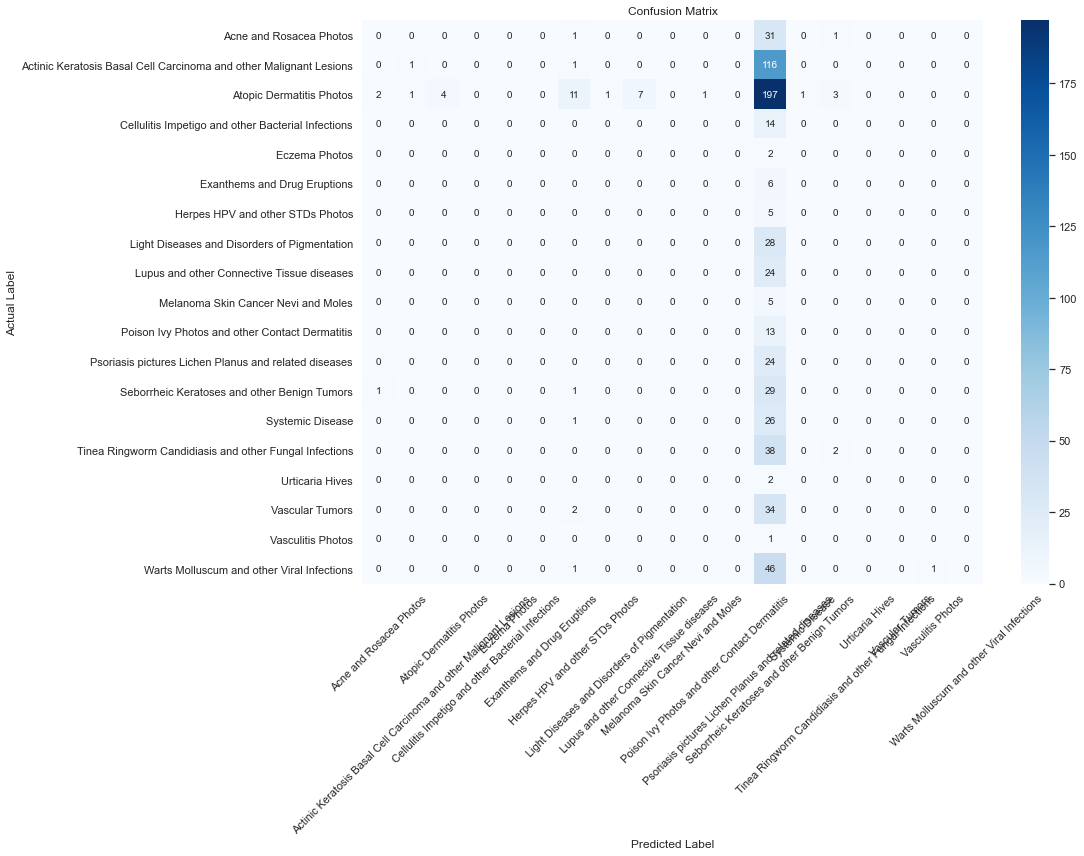

In [45]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
             xticklabels=class_labels,
             yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Document the Model's Performance
The current custom CNN model is **not powerful enough** to extract meaningful features from complex skin lesion images 
as a result the model performs no better than **random guessing** even after proper training and tuning

### Best Fix: Use Transfer Learning
To overcome this limitation  we will use  **transfer learning** which provides:

- A **pretrained CNN backbone** ( MobileNetV2, EfficientNet) trained on **ImageNet**
- Only the **top layers** are fine-tuned for the 19 skin disease classes

This approach:
- Leverages learned visual features from millions of images
- Drastically improves model performance and generalization
- Works well even with **small or imbalanced datasets**


 **Transfer learning is a proven solution in medical imaging tasks and will significantly boost accuracy**



# Use Transfer Learning with EfficientNetB0

We'll use EfficientNetB0, a lightweight yet powerful pretrained model from ImageNet. We'll:

1. Freeze the base layers to retain learned features.

2. Add custom classification layers on top for our 19 skin disease classes.

3. Train only the top layers to prevent overfitting on a small dataset.

In [47]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


### Load pretrained EfficientNetB0

In [48]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all layers in the base model
base_model.trainable = False


16711680/16705208 [==============================] - 9s 1us/step


### Add Custom Classification Head

In [49]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(19, activation='softmax')(x)

# Define the model
model_transfer = Model(inputs=base_model.input, outputs=predictions)


### Compile the Model

In [50]:
model_transfer.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


### Setup Callbacks

In [52]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)